In [1]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 9.5 MB/s eta 0:00:00


In [2]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm
import time

# Data manipulation and visualization
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [3]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


In [4]:
# Mount drive to acess files directly from Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Download EuroSat data and save it in EuroSAT. For simplicity, we will focus on RGB image classification.
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2023-11-01 14:36:08--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  19.4MB/s    in 5.7s    

2023-11-01 14:36:14 (15.7 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [6]:
# Custom Dataset class to load the input and target for a dataset along with their corrsponding labels.
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

In [7]:
# Data agumentation techniques are applied. These perturbations reduce the neural
# network's overfitting to the training dataset, and they allow it to generalize better to the unseen test dataset.
input_size = 224

imagenet_mean, imagenet_std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    # transforms.CenterCrop(input_size),
    transforms.ToTensor()
])

In [8]:
# Load the dataset
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

# Create a SummaryWriter instance to write logs
writer = SummaryWriter()

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


In [9]:
# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 80% train / 20% test
# by subsetting the transformed train and test datasets
train_size = 0.8
indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:split])
test_data = data.Subset(test_data, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))

Train/test sizes: 21600/5400


In [10]:
# Create dataloder to load data and assembele them in batches
num_workers = 2
batch_size = 64

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True
)

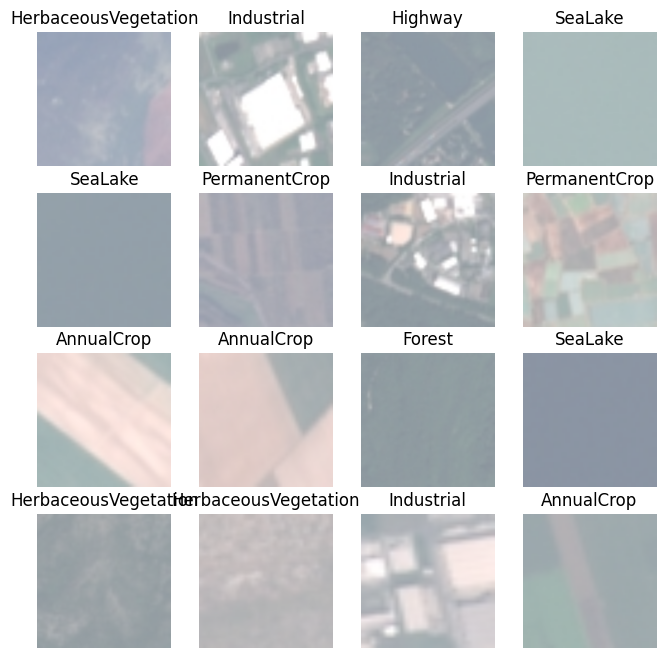

In [11]:
# Visualize batch of the dataset with their LULC labels
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8,8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

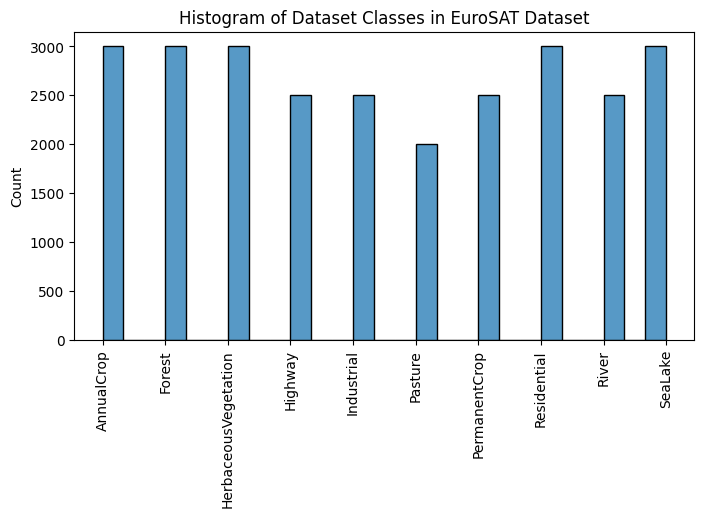

In [12]:
# Explore dataset with number of images in each classes
plt.figure(figsize=(8, 4))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()


In [13]:
# Assuming 'train_data' is already defined as in your code snippet
example_image = train_data[0][0]  # Accessing the first element of the first sample

# Get the input shape of the example image
input_shape = example_image.shape
print("Input shape of the RGB image:", input_shape)
num_classes = len(dataset.classes)
print(num_classes)

Input shape of the RGB image: torch.Size([3, 224, 224])
10


In [14]:
import torch.nn as nn
import torchvision.models as models

class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        # Load the pre-trained ResNet-50 model
        self.model = models.resnet50(pretrained=True)
        # Modify the classification head for the new number of classes
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
# Set the model name and create an instance of the ResNet50Model
model_name = "resnet50-15-epoch-No-Aug"  # You can choose a suitable name
num_classes = len(dataset.classes)  # Assuming you have the dataset defined
model = ResNet50Model(num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.7MB/s]


In [16]:
# Summary of the model
torchsummary.summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:

# Create directories for train and test logs
train_log_dir = os.path.join("logs", model_name, "train")
test_log_dir = os.path.join("logs", model_name, "test")

# Make sure the directories exist
os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

# Create separate TensorBoard writers for train and test logs
train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)




In [18]:
# Settings for model training
n_epochs = 15
lr = 1e-5 #1e-2, 1e-5
weight_decay = 0
grad_clip = 0.1
# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [19]:
# Train function that is responsible for training model
def train(model, dataloader, criterion, optimizer, epoch, writer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()
    # optimizer_freeze.zero_grad()
    # optimizer_train.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Apply gradient clipping
    for param in model.parameters():
      if param.grad is not None:
        param.grad.data = torch.clamp(param.grad.data, -grad_clip, grad_clip)



    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100

  # Log the loss and accuracy for TensorBoard
  writer.add_scalar('Train/Loss', epoch_loss, epoch)
  writer.add_scalar('Train/Accuracy', epoch_accuracy, epoch)

  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [20]:
# Evaluation function to evaluate the model in the test set to observe performance on new, unseen data.
def evaluate(model, dataloader, criterion, epoch, writer):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100

  # Log the loss and accuracy for TensorBoard
  writer.add_scalar('Test/Loss', epoch_loss, epoch)
  writer.add_scalar('Test/Accuracy', epoch_accuracy, epoch)

  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [21]:

# Keep track of the best loss and
# best model weights with the lowest loss
best_loss = np.inf
best_model = None

# Record the start time
start_time = time.time()


# Train and test over n_epochs
for epoch in range(n_epochs):
  # print("Epoch {}".format(epoch+1))
  # train(model, train_loader, criterion, optimizer)
  # test_loss, _ = evaluate(model, test_loader, criterion)
  print("Epoch {}".format(epoch+1))
  train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, epoch, writer)
  test_loss, test_accuracy = evaluate(model, test_loader, criterion, epoch, writer)

  # Log train and test metrics for the current epoch
  writer.add_scalars('Loss', {'Train': train_loss, 'Test': test_loss}, epoch)
  writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
  # Log train and test metrics for the current epoch using appropriate writers
  train_writer.add_scalars('Loss', {'Train': train_loss, 'Test': test_loss}, epoch)
  train_writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
  if test_loss < best_loss:
    best_loss = test_loss
    best_model= model.state_dict()

# Record the end time
end_time = time.time()

# Calculate the total training time
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))

Epoch 1


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.81; Accuracy: 77.80


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.18; Accuracy: 95.15
Epoch 2


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.28; Accuracy: 91.19


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.10; Accuracy: 97.06
Epoch 3


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.22; Accuracy: 92.95


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.07; Accuracy: 98.09
Epoch 4


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.19; Accuracy: 93.75


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.07; Accuracy: 97.83
Epoch 5


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.17; Accuracy: 94.54


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.06; Accuracy: 98.06
Epoch 6


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.16; Accuracy: 94.90


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.06; Accuracy: 98.06
Epoch 7


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.15; Accuracy: 95.07


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.35
Epoch 8


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.15; Accuracy: 95.34


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.41
Epoch 9


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.14; Accuracy: 95.70


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.41
Epoch 10


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.13; Accuracy: 95.62


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.46
Epoch 11


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.13; Accuracy: 96.02


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.30
Epoch 12


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.12; Accuracy: 96.11


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.31
Epoch 13


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.11; Accuracy: 96.45


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.61
Epoch 14


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.11; Accuracy: 96.48


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.26
Epoch 15


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.11; Accuracy: 96.61


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.04; Accuracy: 98.54
Total training time: 3488.49 seconds


In [22]:
# Close the SummaryWriter
writer.close()
train_writer.close()
test_writer.close()

In [23]:
# Save model
model_dir = "./drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

# model_file = model_dir + 'model_name_model.pth'
model_file = os.path.join(model_dir, f'{model_name}_model.pth')

torch.save(best_model, model_file)
print('Model successfully saved to {}'.format(model_file))

Model successfully saved to ./drive/My Drive/Colab Notebooks/models/resnet50-15-epoch_model.pth


In [24]:
# Download logs for monitoring
import shutil
from google.colab import files

# Replace this with the actual path of the folder you want to download
folder_path = '/content/logs'

# Compress the folder into a zip file
shutil.make_archive("/content/logs_download", 'zip', folder_path)

# Download the zip file
files.download('/content/logs_download.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
%load_ext tensorboard

In [26]:
%tensorboard --logdir=logs

<IPython.core.display.Javascript object>

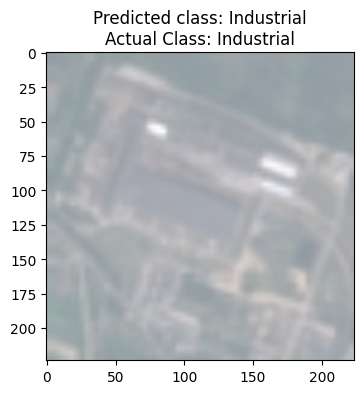

In [27]:
# Retrieve sample image
index = 10
image, label = test_data[index]

image = image.to(device)
# Predict on sample
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

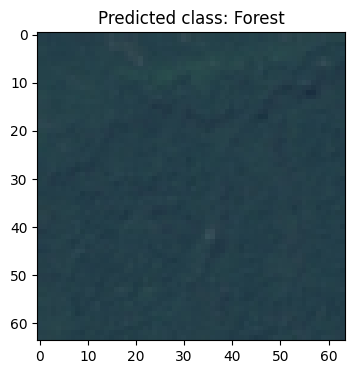

In [28]:
# Run model in PIL image
from PIL import Image
image_path = './EuroSAT/2750/Forest/Forest_2.jpg'
image = Image.open(image_path)

# Transform image
input = test_transform(image)

input = input.to(device)
# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));

In [29]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Assuming you have predictions and true labels
true_labels = [class_names[label] for _, label in test_data]
predicted_labels = []

batch_size = 32  # Adjust this according to your available memory and GPU capacity
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.to(device)
        batch_output = model(batch_images)
        _, batch_preds = torch.max(batch_output, 1)
        predicted_labels.extend([class_names[pred] for pred in batch_preds])

# Convert labels to numerical values for sklearn metrics
label_mapping = {class_name: i for i, class_name in enumerate(class_names)}
true_labels_numeric = [label_mapping[label] for label in true_labels]
predicted_labels_numeric = [label_mapping[label] for label in predicted_labels]

# Calculate different classification metrics
accuracy = accuracy_score(true_labels_numeric, predicted_labels_numeric)
precision = precision_score(true_labels_numeric, predicted_labels_numeric, average='weighted')
recall = recall_score(true_labels_numeric, predicted_labels_numeric, average='weighted')
f1 = f1_score(true_labels_numeric, predicted_labels_numeric, average='weighted')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# Generate classification report
class_report = classification_report(true_labels_numeric, predicted_labels_numeric, target_names=class_names)
print("Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_numeric, predicted_labels_numeric)
print("Confusion Matrix:\n", conf_matrix)

# Rest of the code for visualization


Accuracy: 98.54%
Precision: 0.99
Recall: 0.99
F1-score: 0.99
Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.98      0.98      0.98       597
              Forest       1.00      1.00      1.00       600
HerbaceousVegetation       0.98      0.97      0.98       557
             Highway       0.99      0.98      0.99       493
          Industrial       0.99      0.99      0.99       512
             Pasture       0.97      0.97      0.97       374
       PermanentCrop       0.96      0.97      0.97       491
         Residential       1.00      1.00      1.00       607
               River       0.98      0.99      0.98       547
             SeaLake       1.00      1.00      1.00       622

            accuracy                           0.99      5400
           macro avg       0.98      0.98      0.98      5400
        weighted avg       0.99      0.99      0.99      5400

Confusion Matrix:
 [[583   0   1   0   0   3

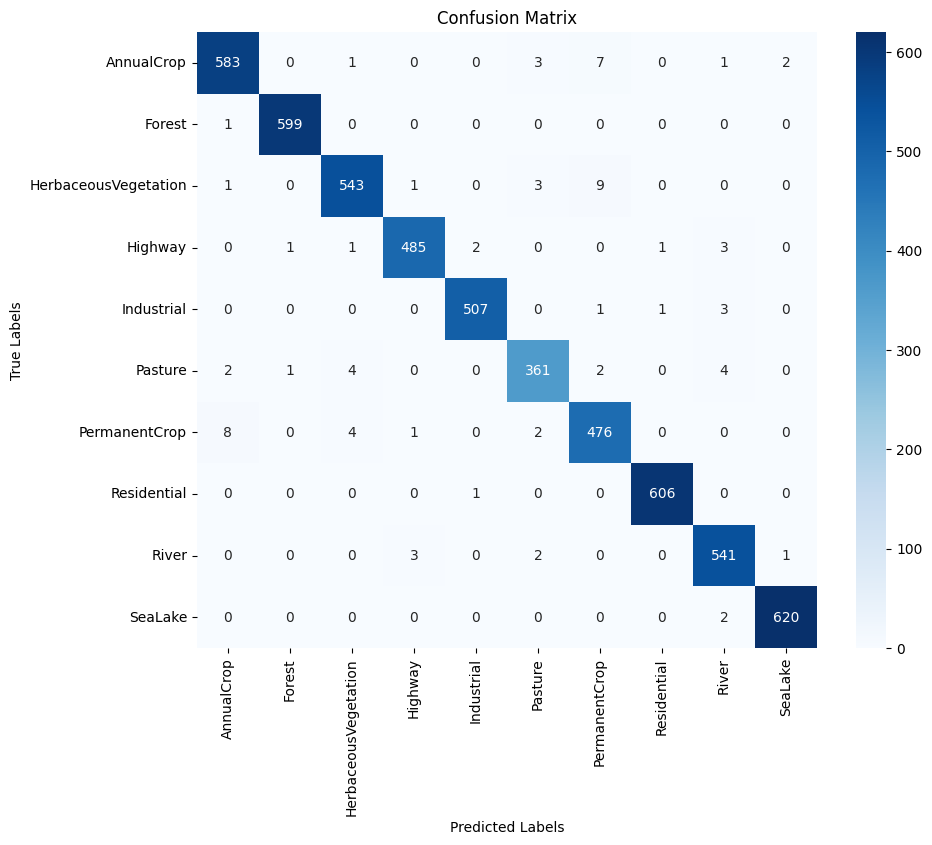

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_numeric, predicted_labels_numeric)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

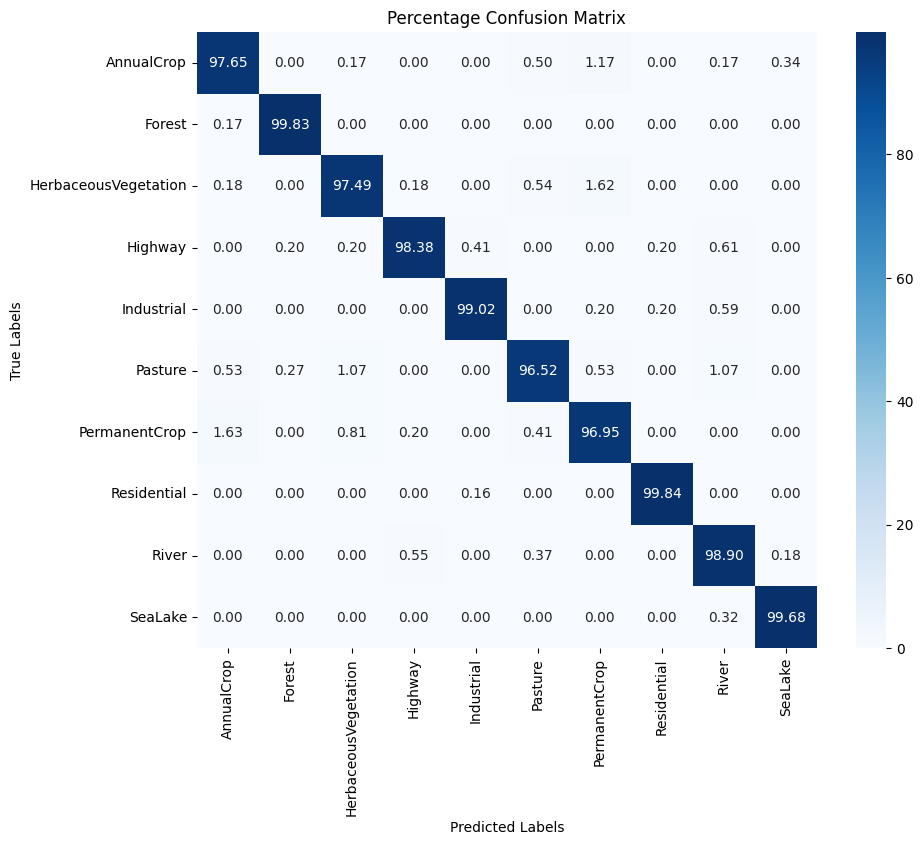

In [31]:
# normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# plt.figure(figsize=(10, 8))
# sns.heatmap(normalized_conf_matrix, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Normalized Confusion Matrix")
# plt.show()

normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
percentage_conf_matrix = normalized_conf_matrix * 100  # Convert to percentages

plt.figure(figsize=(10, 8))
sns.heatmap(percentage_conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Percentage Confusion Matrix")
plt.show()


